In [16]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils, util
import ccores.cores as cores
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from utils import u_darrays as uda
from eod import msg_panAfrica
from utils import u_grid, u_interpolate as u_int
import glob
from utils import constants as cnst
import ipdb

In [15]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
msg_obj = msg_panAfrica.ReadMsg(cnst.lmcs_drive+'SSA_data/', y1=2010, y2=2010, months=[11])

In [54]:
#lls = [-21, 45, -33.2, 26]
lls = [8, 42, -35, 0]

In [91]:
msg_obj.set_date(2010,11,5,22,0)

In [92]:
msg_obj.dpath

'/media/ck/LStorage/global_water/SSA_data/ch9/2010/11/201011052200.gra'

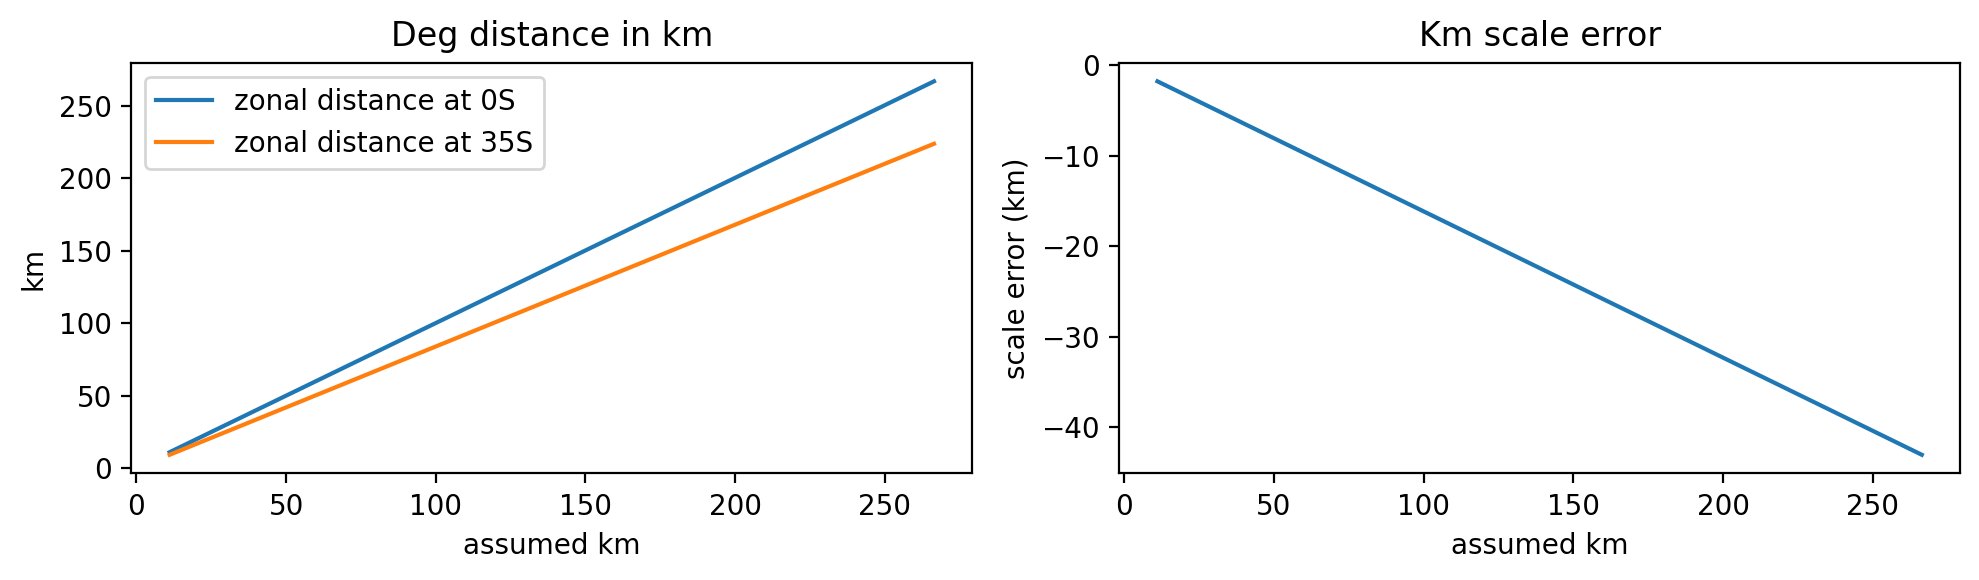

In [93]:
from utils import u_gis

eq = []
south = []
scal = np.arange(0.1,2.5, 0.1)
for scales in scal:
    
    eq.append(u_gis.haversine(0,0,0+scales,0)[0])
    south.append(u_gis.haversine(0,-33, 0+scales, -33)[0])
    
f = plt.figure(figsize=(10,3), dpi=200)
ax = f.add_subplot(121)
ax.plot(scal*111, eq, label='zonal distance at 0S')
ax.plot(scal*111, south, label='zonal distance at 35S')
ax.set_ylabel('km')
ax.set_xlabel('assumed km')
plt.title('Deg distance in km')
plt.legend()


ax = f.add_subplot(122)
ax.plot(scal*111, np.array(south)-np.array(eq))
ax.set_ylabel('scale error (km)')
ax.set_xlabel('assumed km')

plt.title('Km scale error')


plt.tight_layout()


In [94]:
bigds = msg_obj.get_data()

In [95]:
ds = bigds.where((bigds.lon >= lls[0]) & (bigds.lon <= lls[1]) & (bigds.lat >= lls[2]) & (bigds.lat <= lls[3]), drop=True)

In [96]:
# ipos = np.where((ds.lon >= lls[0]) & (ds.lon <= lls[1]) & (ds.lat >= lls[2]) & (ds.lat <= lls[3]))

In [97]:
bigds.lat.shape

(2080, 2268)

In [98]:
ds.lat.shape

(822, 1097)

In [99]:
# subset = ds.isel(x=(ds.x>=ipos[1].min())&(ds.x<=ipos[1].max()), y=(ds.y>=ipos[0].min())&(ds.y<=ipos[0].max()))

In [100]:
np.unique(ds.lat)

array([-38.54228 , -38.528732, -38.51505 , ...,  -9.524634,  -9.524511,
        -9.524409], dtype=float32)

In [101]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
 #   ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-23.0, 52.0)

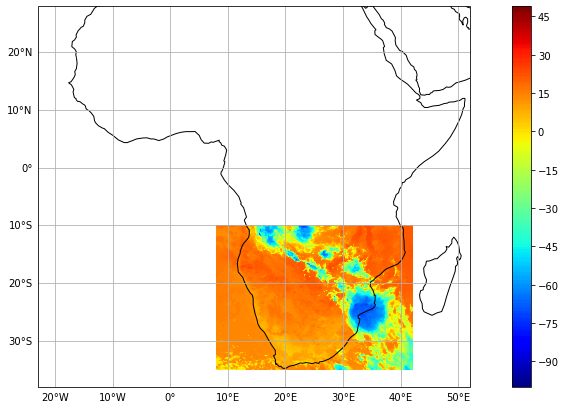

In [102]:
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
ax.set_ylim(-38,28)
ax.set_xlim(-23,52)

In [105]:
data_resolution = 5 # in km
# make salem grid
grid5k = u_grid.make(np.arange(lls[0],lls[1]), np.arange(lls[2],lls[3]), data_resolution*1000)
dlon = ds.lon.squeeze().values.T
dlat = ds.lat.squeeze().values.T
inds, weights, shape = u_int.interpolation_weights_grid(dlon, dlat, grid5k)

In [692]:
# data_resolution = 3 # in km
# # make salem grid
# grid3k = u_grid.make(np.arange(lls[0],lls[1]), np.arange(lls[2],lls[3]), data_resolution*1000)
# dlon = ds.lon.squeeze().values.T
# dlat = ds.lat.squeeze().values.T
# inds3, weights3, shape3 = u_int.interpolation_weights_grid(dlon, dlat, grid3k)

In [106]:
data = ds['t'].squeeze().values.T
try:
    data5k = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lonN, latN = grid5k.ll_coordinates

In [107]:
# regrid5k = grid5k.to_dataset()

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-23.0, 52.0)

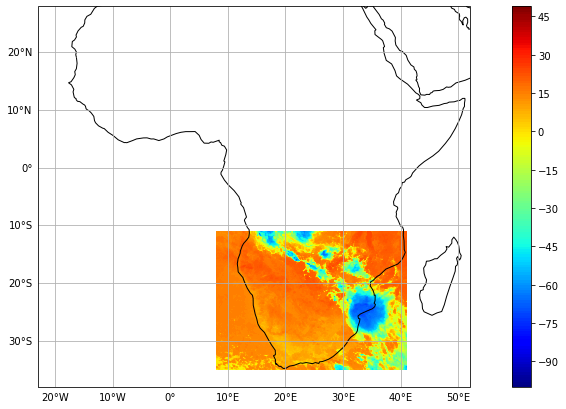

In [108]:
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
draw_map(ax, data5k, lonN, latN, levels=np.arange(-100,50), cmap='jet')
ax.set_ylim(-38,28)
ax.set_xlim(-23,52)

In [109]:
%%time
wObjn = cores.dataset('METEOSAT5K_vera')
wObjn.read_img(data5k, lonN, latN, edge_smoothing=False)
wObjn.applyWavelet(normed='scale')
nowcast = wObjn.scaleWeighting(wtype='nflics')

Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -75.75817660629181 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
CPU times: user 659 ms, sys: 20.1 ms, total: 679 ms
Wall time: 675 ms


In [110]:
%%time
wObj = cores.dataset('METEOSAT3K_test')
wObj.read_img(ds['t'].values, ds.lon.values, ds.lat.values, edge_smoothing=False)
wObj.applyWavelet(normed='scale')
current_nflics = wObj.scaleWeighting(wtype='nflics3k')
new_nflics = wObj.scaleWeighting(wtype='nflics')

Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
CPU times: user 3.38 s, sys: 208 ms, total: 3.59 s
Wall time: 3.59 s


In [111]:
%%time
wObj = cores.dataset('METEOSAT3K_veraLS')
wObj.read_img(ds['t'].values, ds.lon.values, ds.lat.values, edge_smoothing=False)
wObj.applyWavelet(normed='scale')
current_nflics_std = wObj.scaleWeighting(wtype='nflics3k')
new_nflics_std = wObj.scaleWeighting(wtype='nflics')

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
CPU times: user 2.46 s, sys: 180 ms, total: 2.64 s
Wall time: 2.64 s


Text(0.5, 1.0, 'New, stddev normalisation')

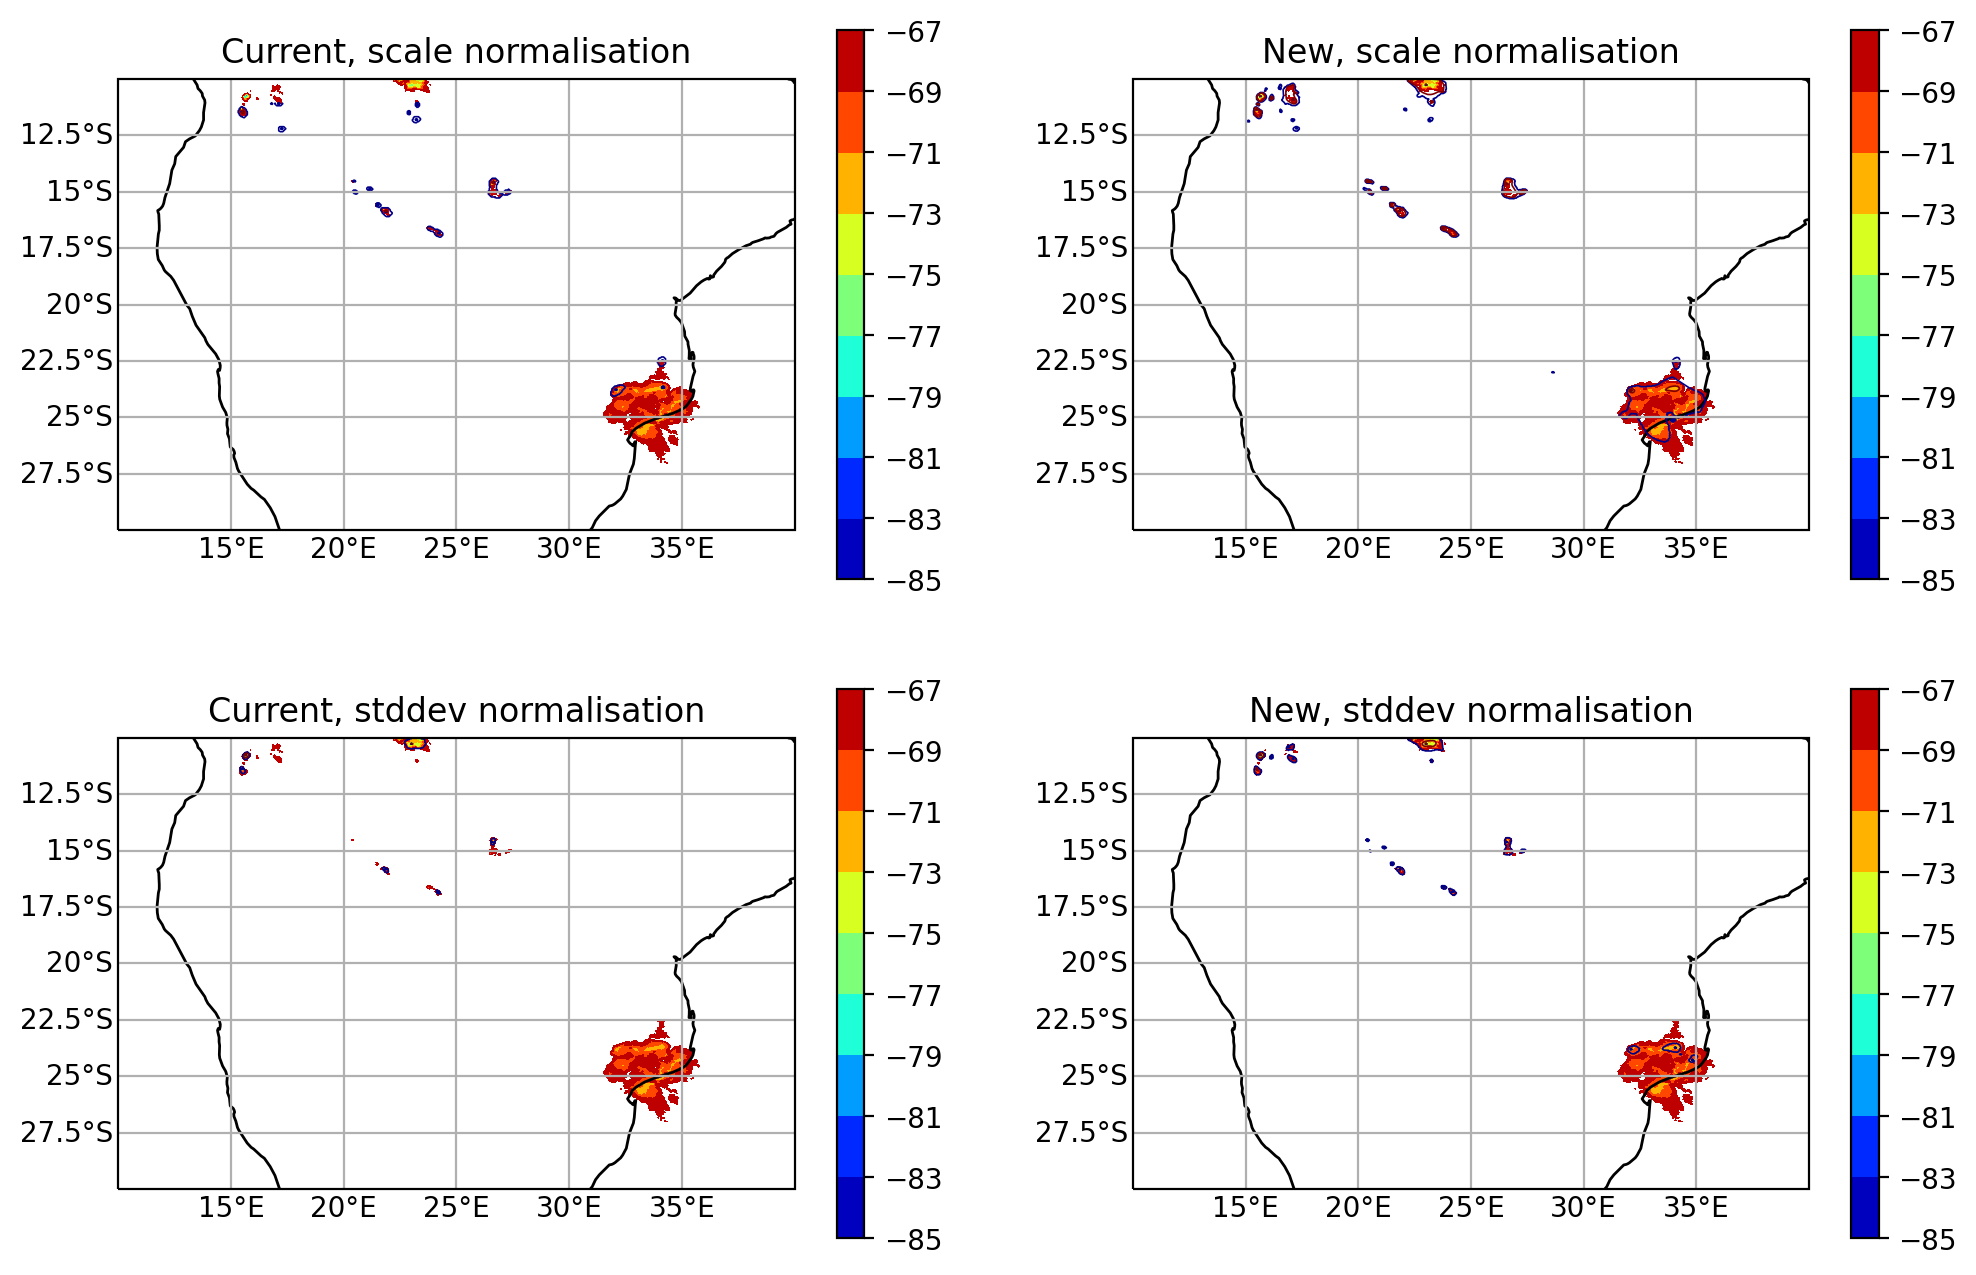

In [118]:
box = [10,40,-30,-10]
tmax = -65
tmin = -85
perc = np.percentile(current_nflics[current_nflics>0],90)
f = plt.figure(figsize=(12,8), dpi=200)
ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax, wObj.original, ds.lon, ds.lat, cmap='jet', levels=np.arange(tmin,tmax,2))
ax.contour(lonN, latN,  nowcast, levels=[-1,0,100], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('Current, scale normalisation')

ax = f.add_subplot(222, projection=ccrs.PlateCarree())
perc = np.percentile(new_nflics[new_nflics>0],90)
draw_map(ax, wObj.original, ds.lon, ds.lat, cmap='jet', levels=np.arange(tmin,tmax,2))
ax.contour(ds.lon, ds.lat,  new_nflics, levels=[-1,0,100], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('New, scale normalisation')

ax = f.add_subplot(223, projection=ccrs.PlateCarree())
perc = np.percentile(current_nflics_std[current_nflics_std>0],90)
draw_map(ax, wObj.original, ds.lon, ds.lat, cmap='jet', levels=np.arange(tmin,tmax,2))
ax.contour(ds.lon, ds.lat,  current_nflics_std, levels=[-1,0,200], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('Current, stddev normalisation')

ax = f.add_subplot(224, projection=ccrs.PlateCarree())
perc = np.percentile(new_nflics_std[new_nflics_std>0],90)
draw_map(ax, wObj.original, ds.lon, ds.lat, cmap='jet', levels=np.arange(tmin,tmax,2))
ax.contour(ds.lon, ds.lat,  new_nflics_std, levels=[-1,0,150], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('New, stddev normalisation')

In [114]:
prcp = xr.open_dataset(glob.glob('/media/ck/LStorage/NFLICS/GPM/2010/11/3B-HHR.MS.MRG.3IMERG.20101105*.1320.V06B*')[0])  #, group='/Grid/'
#prcp = prcp['precipitationCal'].squeeze()
prcp = prcp['IRprecipitation'].squeeze()
# pbox = prcp.sel(lat=slice(np.min(latitudes), np.max(latitudes)), lon=slice(np.min(longitudes),np.max(longitudes)))
#prcp = prcp.sel(lon=slice(-19,0), lat=slice(8,18.5))

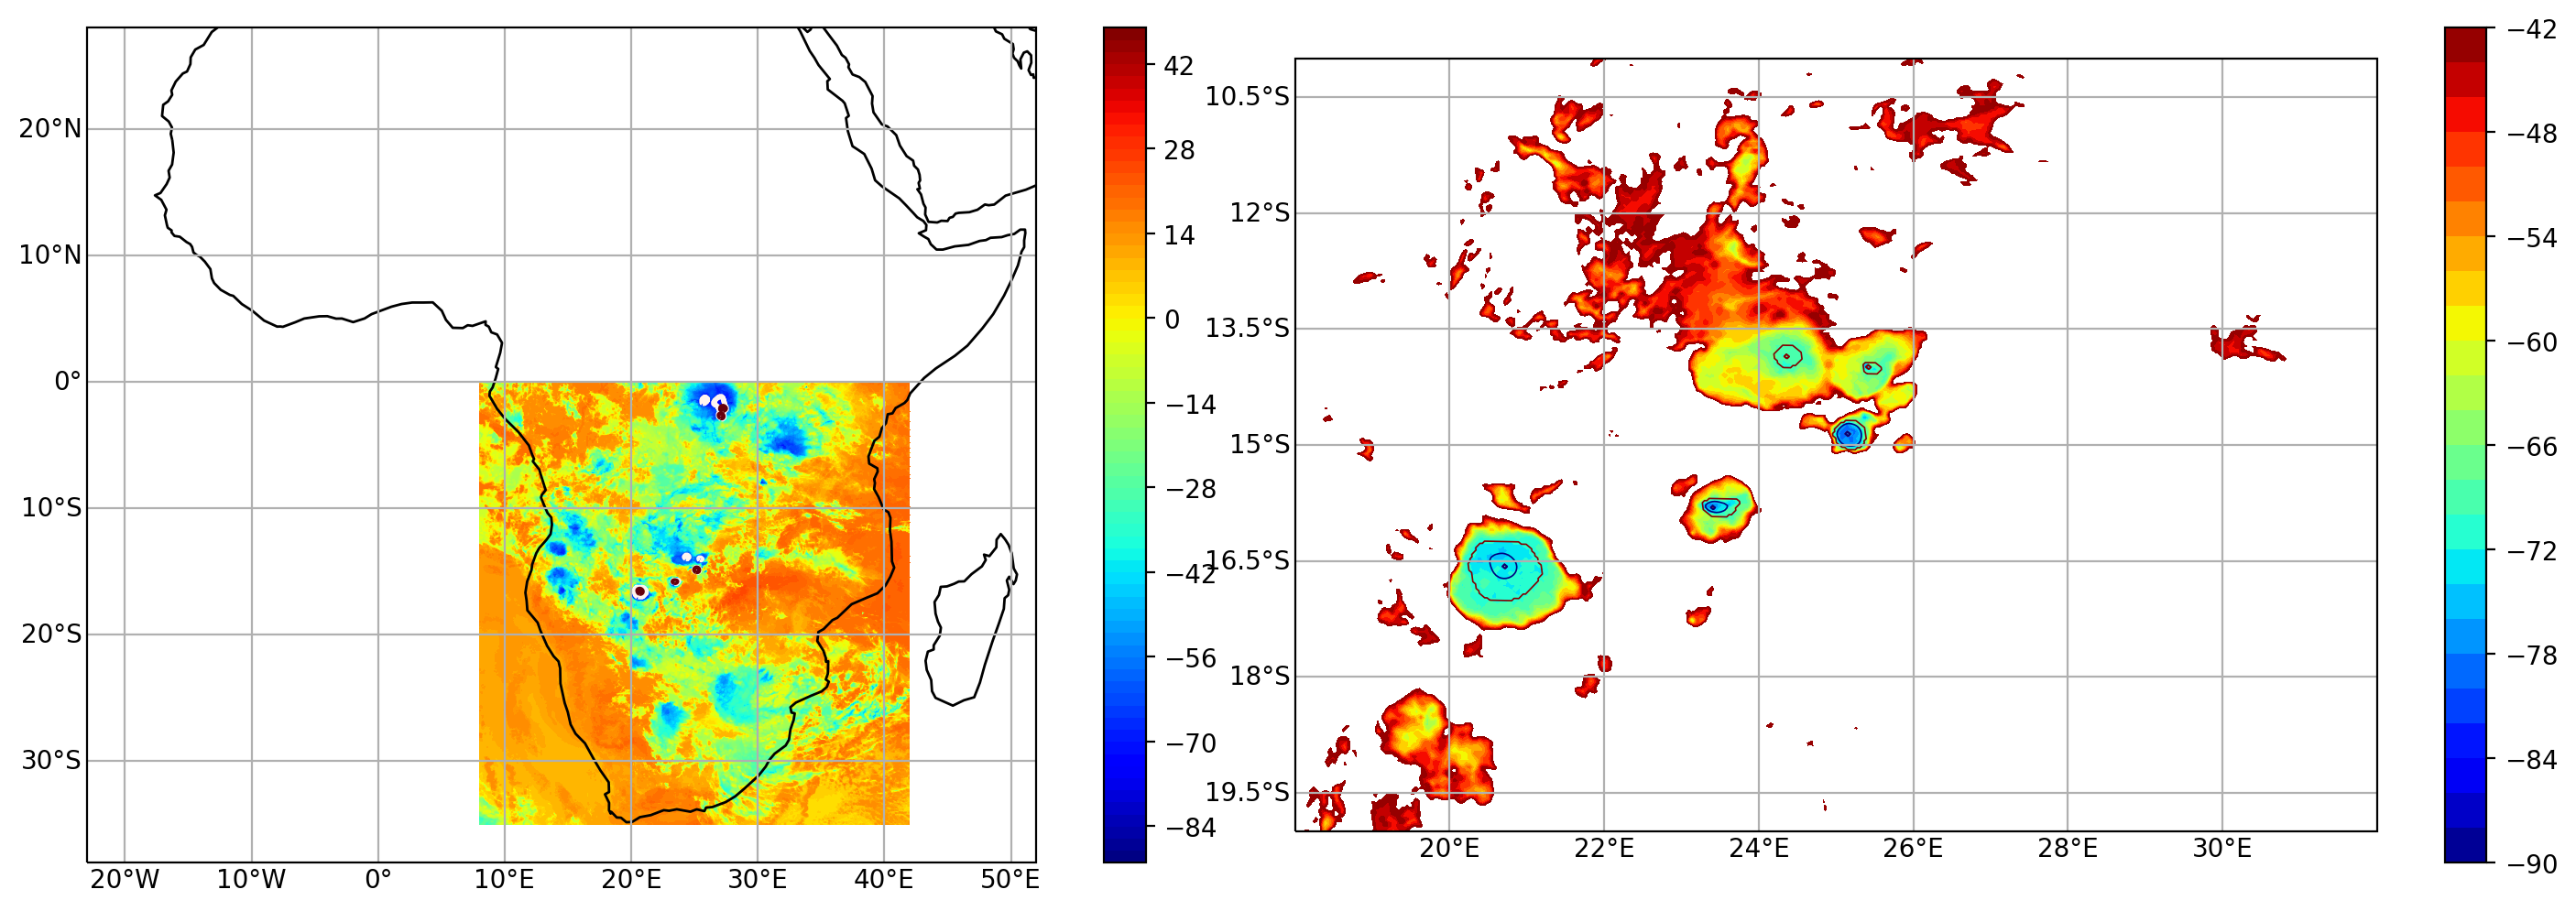

In [75]:

f=plt.figure(figsize=(15,5), dpi=200)  # this opens a plot window
ax = f.add_subplot(121, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
tmin = -90
tmax = 50
draw_map(ax, wObj.original, ds.lon, ds.lat, cmap='jet', levels=np.arange(tmin,tmax,2))
ax.contour(ds.lon, ds.lat,  current_nflics_std, levels=[-1,0,150], cmap='Reds', linewidths=2)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('')
# ax.set_ylim(-38,28)
# ax.set_xlim(-23,52)

box = [18,32,-20,-10]
ax = f.add_subplot(122, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
tmin = -90
tmax = -40
draw_map(ax, wObj.original, ds.lon, ds.lat, cmap='jet', levels=np.arange(tmin,tmax,2))
ax.contour(ds.lon, ds.lat,  current_nflics_std, levels=[-1,0,150], cmap='jet_r', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('')
# ax.set_ylim(-38,28)
# ax.set_xlim(-23,52)
plt.tight_layout()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/map_SAfr.jpg")

Text(0.5, 1.0, 'New, stddev normalisation')

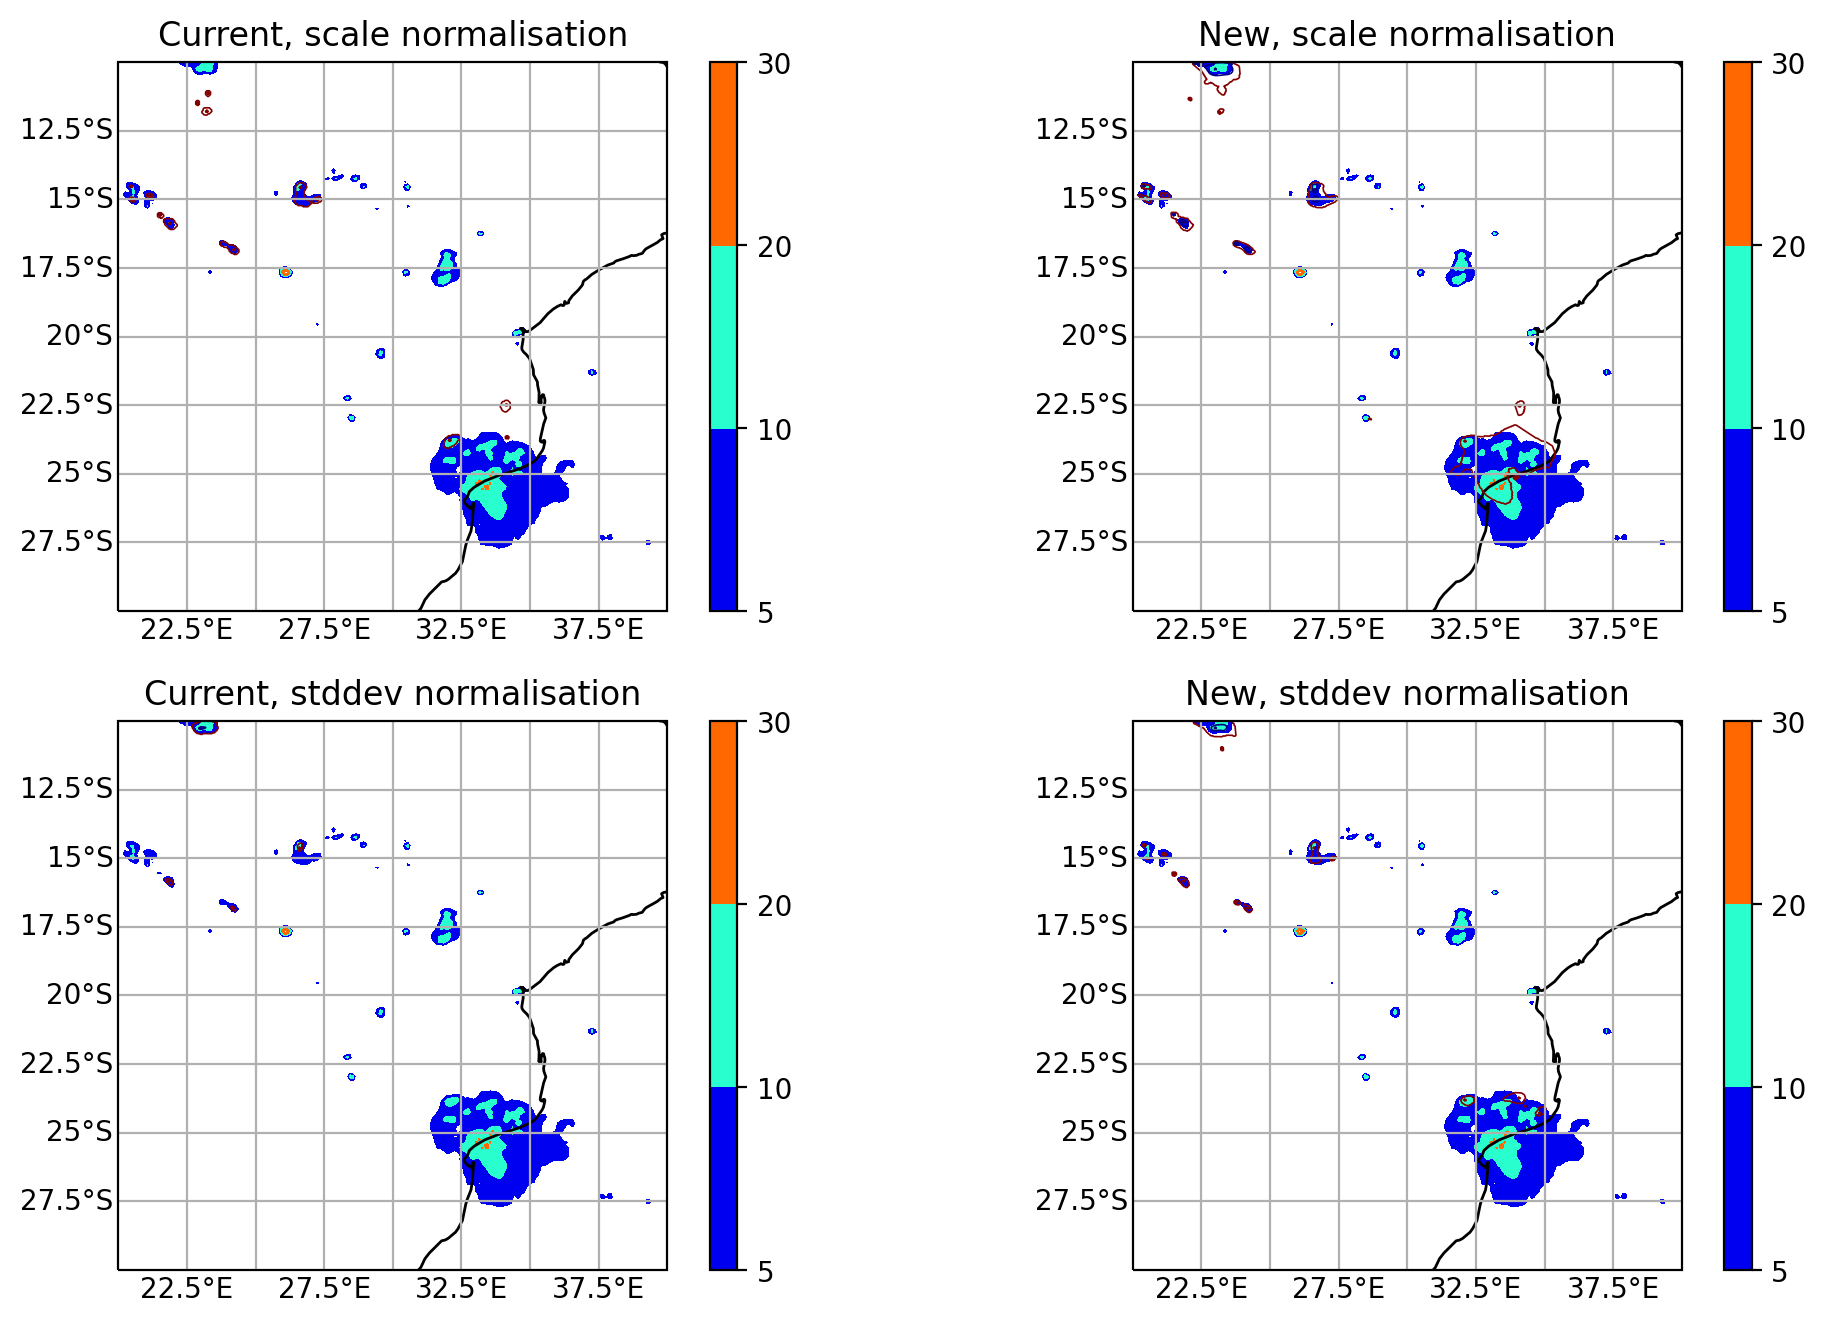

In [115]:

tmax = -40
tmin = -85
prcp = prcp.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
perc = np.percentile(current_nflics[current_nflics>0],90)
f = plt.figure(figsize=(12,8), dpi=200)
ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax,prcp.T, prcp.lon, prcp.lat, cmap='jet', levels=[5,10,20,30])
ax.contour(lonN, latN,  nowcast, levels=[-1,0,perc], cmap='jet_r', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('Current, scale normalisation')

ax = f.add_subplot(222, projection=ccrs.PlateCarree())
perc = np.percentile(new_nflics[new_nflics>0],90)
draw_map(ax,prcp.T, prcp.lon, prcp.lat, cmap='jet', levels=[5,10,20,30])
ax.contour(ds.lon, ds.lat,  new_nflics, levels=[-1,0,perc], cmap='jet_r', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('New, scale normalisation')

ax = f.add_subplot(223, projection=ccrs.PlateCarree())
perc = np.percentile(current_nflics_std[current_nflics_std>0],90)
draw_map(ax,prcp.T, prcp.lon, prcp.lat, cmap='jet', levels=[5,10,20,30])
ax.contour(ds.lon, ds.lat,  current_nflics_std, levels=[-1,0,perc], cmap='jet_r', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('Current, stddev normalisation')

ax = f.add_subplot(224, projection=ccrs.PlateCarree())
perc = np.percentile(new_nflics_std[new_nflics_std>0],90)
draw_map(ax,prcp.T, prcp.lon, prcp.lat, cmap='jet', levels=[5,10,20,30])
ax.contour(ds.lon, ds.lat,  new_nflics_std, levels=[-1,0,perc], cmap='jet_r', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('New, stddev normalisation')

In [76]:
#lls = [5,35,-20,10]

lls = [8, 42, -35, -10]

k3LS = {'rain':[], 'wav' : [], 't' : []}
k3LS_grid = {'rain':[], 'wav' : [], 't' : []}
k3LS_nflics = {'rain':[], 'wav' : [], 't' : []}
k3 = {'rain':[], 'wav' : [], 't' : []}
nflics = {'rain':[], 'wav' : [], 't' : []}
nflicsLS = {'rain':[], 'wav' : [], 't' : []}
alls3k = []
alls3k_reg = []
alls5k = []

msg_obj = msg_panAfrica.ReadMsg(cnst.lmcs_drive+'SSA_data/', y1=2010, y2=2010, months=[11])

msg_obj.set_date(2010,11,2,15,0)
ds = msg_obj.get_data()
ds = ds.where((ds.lon >= lls[0]) & (ds.lon <= lls[1]) & (ds.lat >= lls[2]) & (ds.lat <= lls[3]), drop=True)
dlon = ds.lon.squeeze().values.T
dlat = ds.lat.squeeze().values.T
data = ds['t'].squeeze().values.T

prcp = xr.open_dataset(glob.glob('/media/ck/LStorage/NFLICS/GPM/2010/11/3B-HHR.MS.MRG.3IMERG.20101116*.0000.V06B*')[0])
prcp = prcp['precipitationCal'].squeeze()
prcp = prcp.sel(lon=slice(lls[0]-0.5,lls[1]+0.5), lat=slice(lls[2]-0.5,lls[3]+0.5))
print(prcp.values.shape)

data_resolution = 3 # in km
# make salem grid
grid3k = u_grid.make(np.arange(lls[0],lls[1]), np.arange(lls[2],lls[3]), data_resolution*1000)
inds3, weights3, shape3 = u_int.interpolation_weights_grid(dlon, dlat, grid3k)
data_resolution = 5 # in km
# make salem grid
grid5k = u_grid.make(np.arange(lls[0],lls[1]), np.arange(lls[2],lls[3]), data_resolution*1000)
inds5, weights5, shape5 = u_int.interpolation_weights_grid(dlon, dlat, grid5k)


#data3k = u_int.interpolate_data(data, inds3, weights3, shape3)
lon3k, lat3k = grid3k.ll_coordinates

#data5k = u_int.interpolate_data(data, inds, weights, shape)
lon5k, lat5k = grid5k.ll_coordinates


lons, lats = np.meshgrid(prcp.lon.values, prcp.lat.values)
indsp3, weightsp3, shapep3 = u_int.interpolation_weights(prcp.lon, prcp.lat , lon3k, lat3k)

indsp5, weightsp5, shapep5 = u_int.interpolation_weights(prcp.lon, prcp.lat , lon5k, lat5k)

inds_msg, weights_msg, shape_msg = u_int.interpolation_weights(prcp.lon, prcp.lat , dlon, dlat)


for dd in range(1,31):
    for hh in range(14,24):
       # for mins in [0,30]:
        
        print('Doing ', 2010, 11, dd, hh)
       
        msg_obj.set_date(2010,11,dd,hh,0)
        ds = msg_obj.get_data()
        ds = ds.where((ds.lon >= lls[0]) & (ds.lon <= lls[1]) & (ds.lat >= lls[2]) & (ds.lat <= lls[3]), drop=True)
        dlon = ds.lon.squeeze().values.T
        dlat = ds.lat.squeeze().values.T
        data = ds['t'].squeeze().values.T
        
        t3k = u_int.interpolate_data(data, inds3, weights3, shape3)
        t5k = u_int.interpolate_data(data, inds5, weights5, shape5)
        
        wObj = cores.dataset('METEOSAT3K_veraLS')
        wObj.read_img(data, dlon, dlat, edge_smoothing=False)
        wObj.applyWavelet(normed='scale')
        k3small = wObj.scaleWeighting(wtype='nflics3k')
        k3coarse = wObj.scaleWeighting(wtype='nflics')
        
        wObj = cores.dataset('METEOSAT3K_veraLS')
        wObj.read_img(t3k, lon3k, lat3k, edge_smoothing=False)
        wObj.applyWavelet(normed='scale')
        k3small_regrid = wObj.scaleWeighting(wtype='nflics3k')
        
        wObj = cores.dataset('METEOSAT3K_test')
        wObj.read_img(data, dlon, dlat, edge_smoothing=False)
        wObj.applyWavelet(normed='scale')
        k3_fine = wObj.scaleWeighting(wtype='nflics3k')
        
       # ipdb.set_trace()
        wObj = cores.dataset('METEOSAT5K_vera')
        wObj.read_img(t5k, lon5k, lat5k, edge_smoothing=False)
        wObj.applyWavelet(normed='scale')
        k5_nflics = wObj.scaleWeighting(wtype='nflics')
        
        wObj = cores.dataset('METEOSAT5K_veraLS')
        wObj.read_img(t5k, lon5k, lat5k, edge_smoothing=False)
        wObj.applyWavelet(normed='scale')
        k5_nflicsLS = wObj.scaleWeighting(wtype='nflics')


        gpm_hour = hh*60-30
        #ipdb.set_trace()
        prcp = xr.open_dataset(glob.glob('/media/ck/LStorage/NFLICS/GPM/2010/11/3B-HHR.MS.MRG.3IMERG.201011'+str(dd).zfill(2)+'*.'+str(gpm_hour).zfill(4)+'.V06B*')[0])  #, group='/Grid/'
        
        prcp = prcp['precipitationCal'].squeeze()
        prcp = prcp.sel(lon=slice(lls[0]-0.5,lls[1]+0.5), lat=slice(lls[2]-0.5,lls[3]+0.5))
        print(prcp.values.shape)
        try:
            prcp_5k = u_int.interpolate_data(prcp.T.values, indsp5, weightsp5, shapep5)
            prcp_3k = u_int.interpolate_data(prcp.T.values, indsp3, weightsp3, shapep3)
            prcp_msg = u_int.interpolate_data(prcp.T.values, inds_msg, weights_msg, shape_msg)
            #ipdb.set_trace()
        except IndexError:
            ipdb.set_trace()
            print('Interpolation problem, continue')
        
        thresh = 1
        try:
            ispos_3k = np.where((k3small != 0) & (prcp_msg >=thresh)) # large-scale 3k, with new nflics weighting
            ispos_3knf = np.where((k3coarse != 0) & (prcp_msg >=thresh)) #large-scale 3k, with current nflics weithing
            ispos_3knfine = np.where((k3_fine != 0) & (prcp_msg >=thresh)) # fine-scale 3k with more scales, with new nflics weighting (most different)
            ispos_3msg = np.where((k3small_regrid != 0) & (prcp_3k >=thresh)) # large-scale 3k, with new nflics weithing regridded to regular 3km 
            ispos_5k = np.where((k5_nflics != 0) & (prcp_5k >=thresh)) # current nflics (5k, only 3 scales, nflics weighting)
            ispos_5kLS = np.where((k5_nflicsLS != 0) & (prcp_5k >=thresh)) # potential new 5k, 5 scales, nflics weithing  [none uses smoothing here!!]
        except:
            continue
            
        k3LS['rain'].extend(prcp_msg[ispos_3k].flat)
        k3LS_grid['rain'].extend(prcp_msg[ispos_3knf].flat)
        k3['rain'].extend(prcp_msg[ispos_3knfine].flat)
        k3LS_nflics['rain'].extend(prcp_3k[ispos_3msg].flat)
        nflics['rain'].extend(prcp_5k[ispos_5k].flat)
        nflicsLS['rain'].extend(prcp_5k[ispos_5kLS].flat)
        
        k3LS['wav'].extend(k3small[ispos_3k].flat)
        k3LS_grid['wav'].extend(k3coarse[ispos_3knf].flat)
        k3['wav'].extend(k3_fine[ispos_3knfine].flat)
        k3LS_nflics['wav'].extend(k3small_regrid[ispos_3msg].flat)
        nflics['wav'].extend(k5_nflics[ispos_5k].flat)
        nflicsLS['wav'].extend(k5_nflicsLS[ispos_5kLS].flat)
        
        k3LS['t'].extend(data[ispos_3k].flat)
        k3LS_grid['t'].extend(data[ispos_3knf].flat)
        k3['t'].extend(data[ispos_3knfine].flat)
        k3LS_nflics['t'].extend(t3k[ispos_3msg].flat)
        nflics['t'].extend(t5k[ispos_5k].flat)
        nflicsLS['t'].extend(t5k[ispos_5kLS].flat)
        
        
        alls3k.extend(prcp_msg[prcp_msg>=thresh].flat)
        alls3k_reg.extend(prcp_3k[prcp_3k>=thresh].flat)
        alls5k.extend(prcp_5k[prcp_5k>=thresh].flat) 

        

(340, 197)
Doing  2010 11 1 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -86.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -85.99166240276573 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -86.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 1 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -77.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -76.65019423913098 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -77.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -86.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -84.62486408258397 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -86.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 17

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -87.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -81.84386856061931 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -87.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 17

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -82.9227660291146 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177

(340, 197)
Doing  2010 11 3 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -74.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -73.75269184873082 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -74.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -89.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -88.09760394596135 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -89.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 17

(340, 197)
Doing  2010 11 4 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -80.28466905078861 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 5 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -90.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -86.52055071673456 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -90.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 5 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -88.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -87.00000000000001 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -88.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 6 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -85.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -83.93098231870968 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -85.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 6 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -89.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -88.76852106063563 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -89.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 7 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -94.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -92.53126887584094 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -94.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 7 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -91.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -87.9846375976774 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -91.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale

(340, 197)
Doing  2010 11 8 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -87.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -83.52425184070232 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -87.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 8 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -81.28468409227067 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -81.51719326793166 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 17

(340, 197)
Doing  2010 11 9 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -79.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -78.05780250550323 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -79.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 10 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -86.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -84.78264189643932 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -86.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

(340, 197)
Doing  2010 11 10 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -89.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -87.88407002037948 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -89.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

(340, 197)
Doing  2010 11 11 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -87.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -85.80490390013215 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -87.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

(340, 197)
Doing  2010 11 11 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -79.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -77.22944964349269 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -79.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

(340, 197)
Doing  2010 11 12 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -80.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -79.80533951632079 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -80.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

(340, 197)
Doing  2010 11 12 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -81.93279160743957 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

(340, 197)
Doing  2010 11 13 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -77.97455525278068 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

(340, 197)
Doing  2010 11 13 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -86.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -85.8918876916722 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -86.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

(340, 197)
Doing  2010 11 14 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -78.80185467317037 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

(340, 197)
Doing  2010 11 14 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"

(340, 197)
Doing  2010 11 15 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -82.43339538229336 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

(340, 197)
Doing  2010 11 15 19
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -78.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -76.67005875492299 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -78.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "sca

Doing  2010 11 16 14
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -81.84788363514113 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stdde

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.27369203684

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -87.56783029213581 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -88.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -86.72690993843109 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -80.55802938114832 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -80.53972255027405 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -89.15755013918242 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -90.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -89.70704681056475 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -83.83736796148537 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -84.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -83.7958268065268 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -83.93570843617073 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -85.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -83.85527186179807 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -82.48554040975398 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -82.20522789418051 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -85.88915951597461 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -87.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -84.66974983761764 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scal

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -89.85449100623 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -90.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -88.76667404332188 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale",

power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -84.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -84.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -84.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWe

Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -87.51855503506758 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -88.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -87.83172773942202 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting


power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -87.73455259968391 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -88.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -86.25663627263685 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit dat

power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -80.27152259684765 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -79.986565717525 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_

Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -84.15575131949912 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -86.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -83.62901525924309 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting


power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -83.69768919185078 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -84.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -83.31115384802902 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit dat

power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -87.90377603594482 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -88.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -87.26940927022525 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit dat

Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -80.84269228799437 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -81.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -80.69175371657136 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting


Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -83.98195637727133 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -84.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -83.96642330582637 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
o

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
outmin -83.77769533754774 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -84.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -84.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -84.0 0

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -87.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -85.72519008475106 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -85.72519008475106 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, ple

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -82.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -82.00000000000001 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -82.00000000000001 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, ple

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -85.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -83.75184431988183 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -83.75184431988183 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, ple

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -83.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -81.69265529730357 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -81.69265529730357 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, ple

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -90.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -87.77441860417582 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -87.77441860417582 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, ple

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -90.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -85.1688871787749 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -85.1688871787749 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, pleas

Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -90.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -88.67326965006781 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -88.67326965006781 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, ple

power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -91.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -90.37262819574059 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -90.37262819574059 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
(340, 197)
Doing  2010 11 2

power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -89.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -86.51851674106418 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -86.51851674106418 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
(340, 197)
Doing  2010 11 3

power threshold 86.20994625645575
Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -79.0 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Initialised wavelet with scales:  [25.         35.35533906 50.        ]
outmin -78.33953361290713 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
Initialised wavelet with scales:  [ 25.          35.35533906  50.          70.71067812 100.        ]
outmin -78.33953361290713 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
(340, 197)
Doing  2010 11 3

In [1]:
import pickle as pkl
strt = {}
for dat in ['3km LS, 3k weighting', '3km LS, nflics weighting',  '3km small, 3kweighting', '3km LS, 3k regridded, 3k weighting', '5k, nflics', '5k LS definition, nflics weighting','3k native rain', '3k regrid rain', '5k rain']:
    strt[dat]=pkl.load(open("/home/ck/DIR/cornkle/data/nflics/core_tests/"+dat+".p", "rb"))

keys = strt.keys()
    

In [4]:
plt.contourf(lon5k, lat5k, t5k)
plt.contour(lon5k, lat5k, prcp_5k, levels=[1,5,10])

NameError: name 'lon5k' is not defined

In [2]:
def calc_treshReached(dat, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat))

In [3]:
def calc_treshReached_vsObs(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat)) / np.sum(np.array(obs)>thresh)/np.sum(np.isfinite(obs))

In [4]:
def calc_treshMissed(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [5]:
def percentile(dat, wav, thresh, perc):
    pval = np.percentile(wav, perc)
    dats = np.array(dat)[np.array(wav)>=pval]
    return np.sum(dats>thresh)/np.sum(np.isfinite(dats))

In [6]:
def calc_treshMissed(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [8]:
treached = []
tnames = []
for kk in strt.keys():
    try:
        dat = strt[kk]['rain']
    except:
        dat = strt[kk]
    cc = calc_treshReached(dat,20)
    print(cc, kk)
    treached.append(cc)
    tnames.append(kk)

0.035083690494330855 3km LS, 3k weighting
0.02482111651287514 3km LS, nflics weighting
0.030337206319278557 3km small, 3kweighting
0.027049229939923362 3km LS, 3k regridded, 3k weighting
0.01708474236520757 5k, nflics
0.018535332136203755 5k LS definition, nflics weighting
0.007896279230061157 3k native rain
0.005558069276729324 3k regrid rain
0.005558382945938996 5k rain


In [656]:
# #save percentiles for filter or contour use
# for dat in [(k3LS, '3km LS, 3k weighting'), (k3LS_grid, '3km LS, nflics weighting'), (k3, '3km small, 3kweighting'), (k3LS_nflics, '3km LS, 3k regridded, 3k weighting'), (nflics, '5k, nflics'), (nflicsLS, '5k LS definition, nflics weighting')]:
#     perc = np.percentile(dat[0]['wav'], np.arange(50,100,5))
#     print(perc)
#     pkl.dump(perc, open("/home/ck/DIR/cornkle/data/nflics/core_tests/"+dat[1]+"_50-95_5step_percentiles.p", "wb"))

[145.68925912 154.6045336  164.40441867 175.49540259 188.14664331
 202.78138813 219.82352822 241.0763581  270.31755423 316.79180866]
[102.74613829 111.73680907 121.8930548  133.27193065 146.28414377
 161.59669112 180.14323807 203.33182855 233.80664645 283.38017364]
[281.94459958 297.05066143 313.73431319 332.4328058  353.72631993
 378.22639069 407.24986078 443.01907842 490.6509716  567.7480026 ]
[142.26155914 150.72534661 160.10214619 170.65636706 182.75239252
 196.54562398 212.96568346 233.51007126 262.24086651 308.59514012]
[ 39.83819145  44.06957418  48.95269823  54.68772905  61.54554385
  69.90648702  80.55575274  94.77742261 115.38045487 151.78379602]
[ 81.36445366  89.23964238  98.27792328 108.54026771 120.40546614
 134.19061669 150.97449914 173.15149292 204.38659597 255.72803878]


In [ ]:
tcaught = []
for kk in strt.keys():
    try:
        dat = strt[kk]['rain']
    except:
        continue
    if '3k' in kk:
        ipdb.set_trace()
        precip  = strt['3k native rain']
    else:
        precip = strt['5k rain']
    
    cc = calc_treshMissed(dat,precip, 30)
    print(cc, dat, len(dat))
    tcaught.append(cc)

> <ipython-input-18-91b8225d7357>(9)<module>()
      8         ipdb.set_trace()
----> 9         precip  = strt['3k native rain']
     10     else:

ipdb> strt['3k native rain']


In [613]:
tfrac = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting', alls3k), (k3LS_grid['rain'], '3km LS, nflics weighting', alls3k), (k3['rain'], '3km small, 3kweighting', alls3k), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting', alls3k_reg), (nflics['rain'], '5k, nflics', alls5k), (nflicsLS['rain'], '5k LS definition, nflics weighting', alls5k)]:

    cc = calc_treshReached_vsObs(dat[0],dat[2], 25)
    print(cc, dat[1])
    tfrac.append(cc)

2.9040804540859075e-14 3km LS, 3k weighting
2.0591490639522683e-14 3km LS, nflics weighting
2.520622479993889e-14 3km small, 3kweighting
2.478752692238593e-14 3km LS, 3k regridded, 3k weighting
1.2352462035933699e-13 5k, nflics
1.3468025093351036e-13 5k LS definition, nflics weighting


In [589]:
for tr, tc, tn in zip(treached,tcaught,tnames):
    print(tr*tc, tn)

0.006550512212183412 3km LS, 3k weighting
0.005498732818136278 3km LS, nflics weighting
0.005985859042224944 3km small, 3kweighting
0.004189964632383902 3km LS, 3k regridded, 3k weighting
0.0026050795786471763 5k, nflics
0.003574765559954474 5k LS definition, nflics weighting


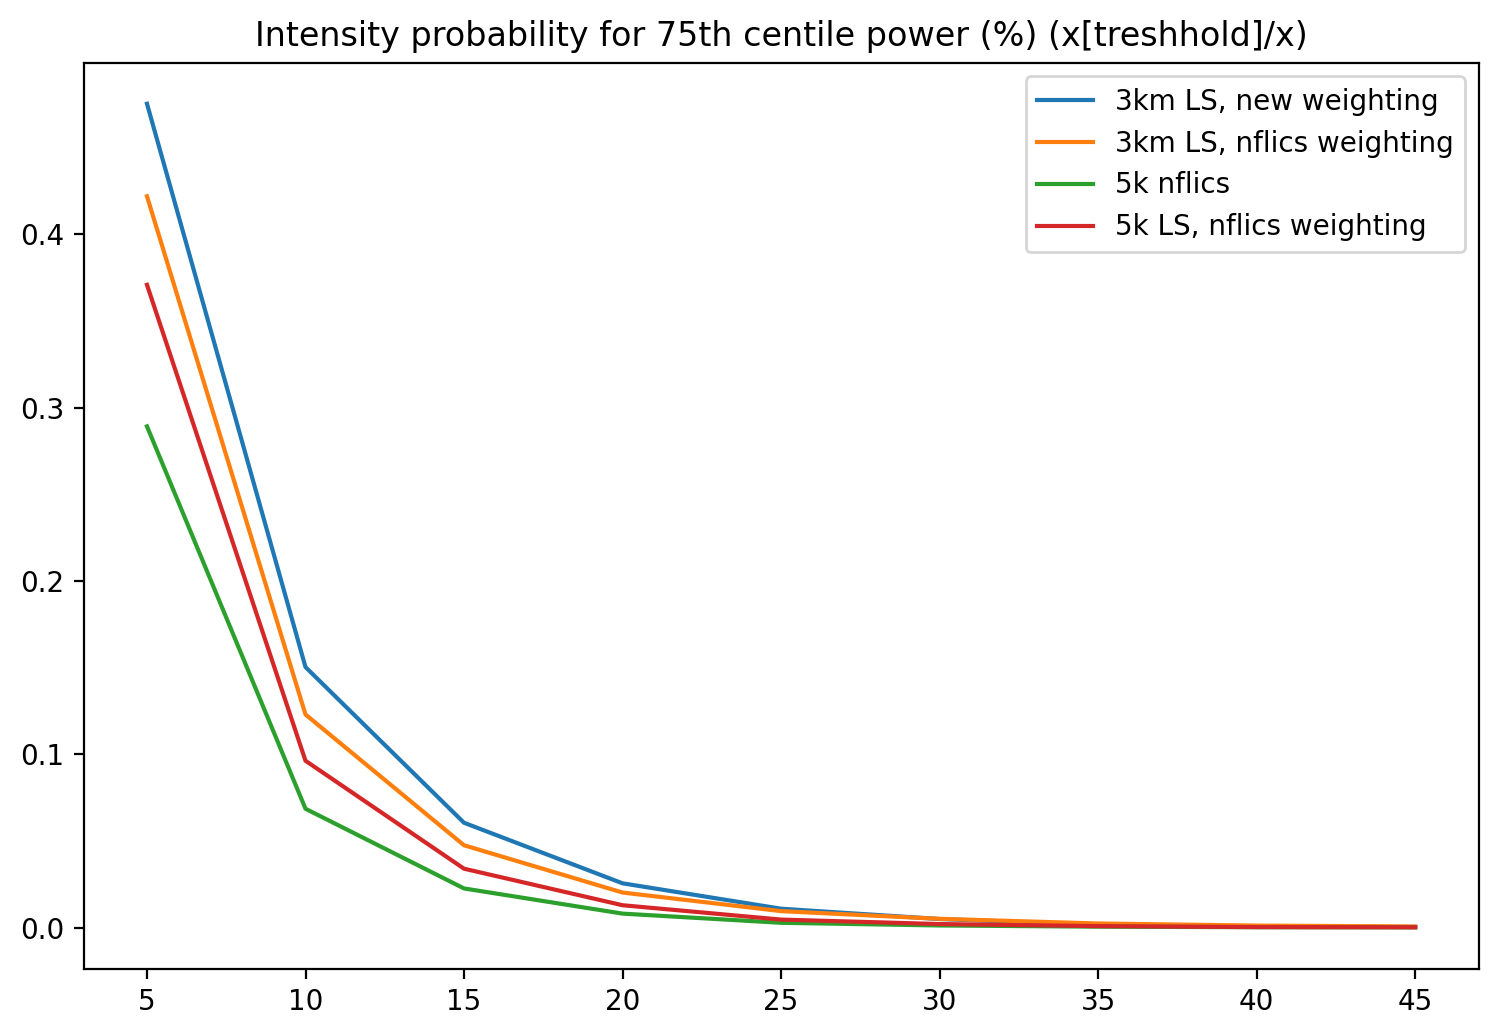

In [83]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS, '3km LS, new weighting'), (k3LS_grid, '3km LS, nflics weighting'), (nflics, '5k nflics'), (nflicsLS, '5k LS, nflics weighting')]:
    treached = []
    for intens in range(5,50,5):
        cc = percentile(dat[0]['rain'],dat[0]['wav'], intens, 75)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability for 75th centile power (%) (x[treshhold]/x)")
plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_75p_wpower.jpg')

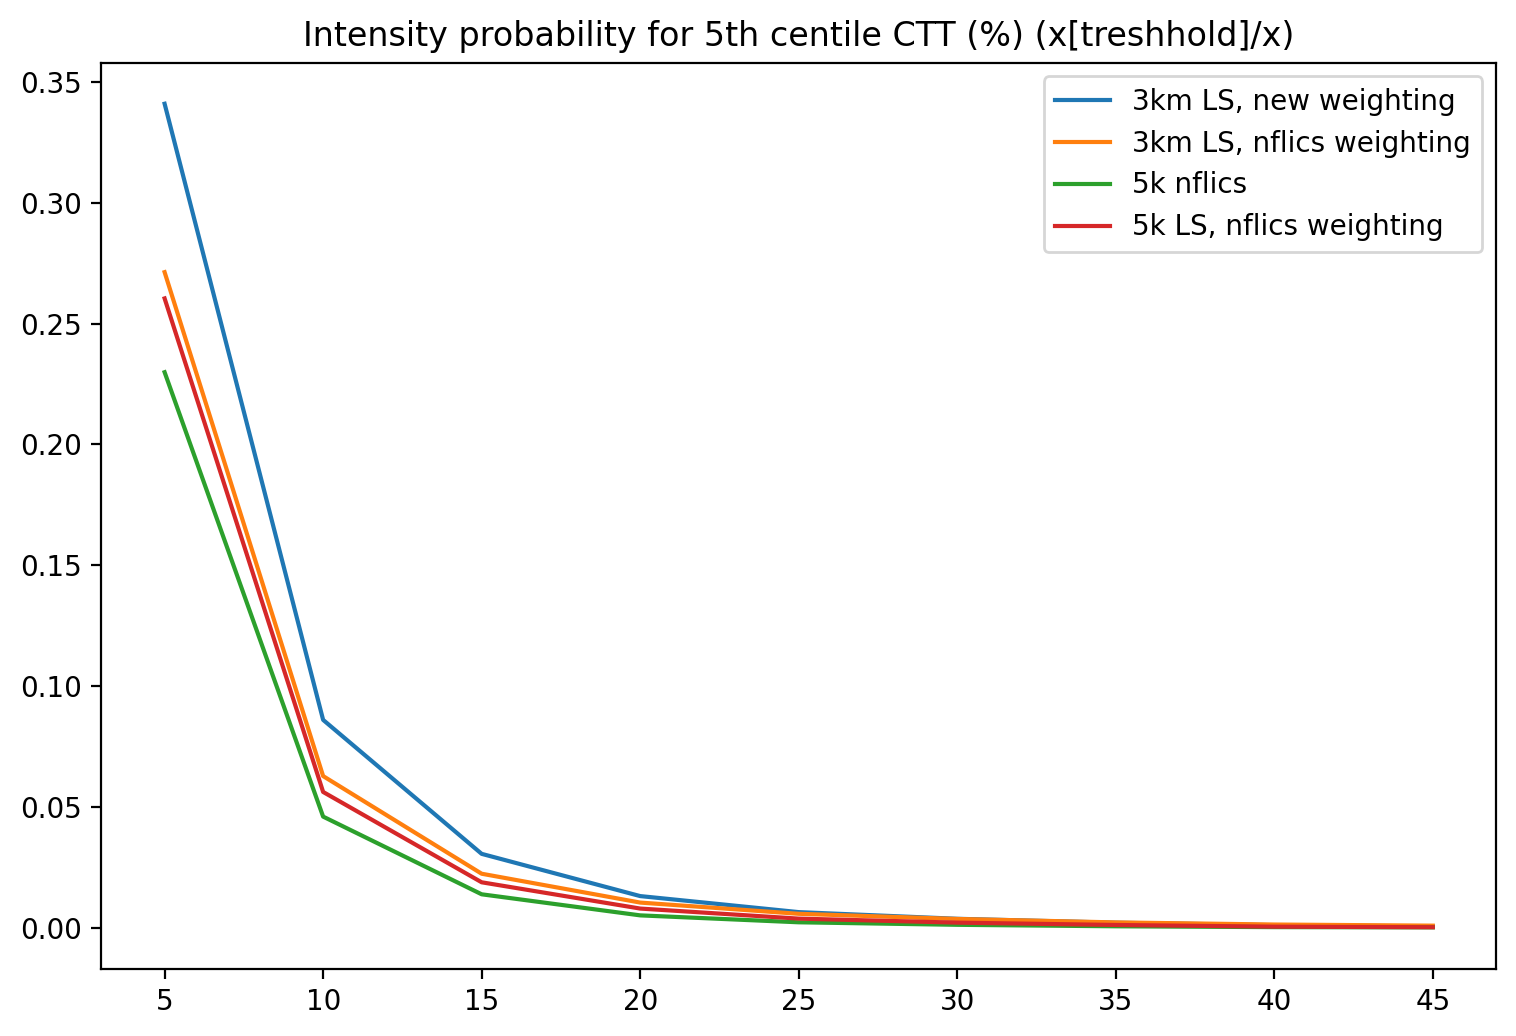

In [84]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS, '3km LS, new weighting'), (k3LS_grid, '3km LS, nflics weighting'),  (nflics, '5k nflics'), (nflicsLS, '5k LS, nflics weighting')]:
    treached = []
    for intens in range(5,50,5):
        cc = percentile(dat[0]['rain'],dat[0]['t'], intens, 5)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability for 5th centile CTT (%) (x[treshhold]/x)")
plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_5pCTT.jpg')

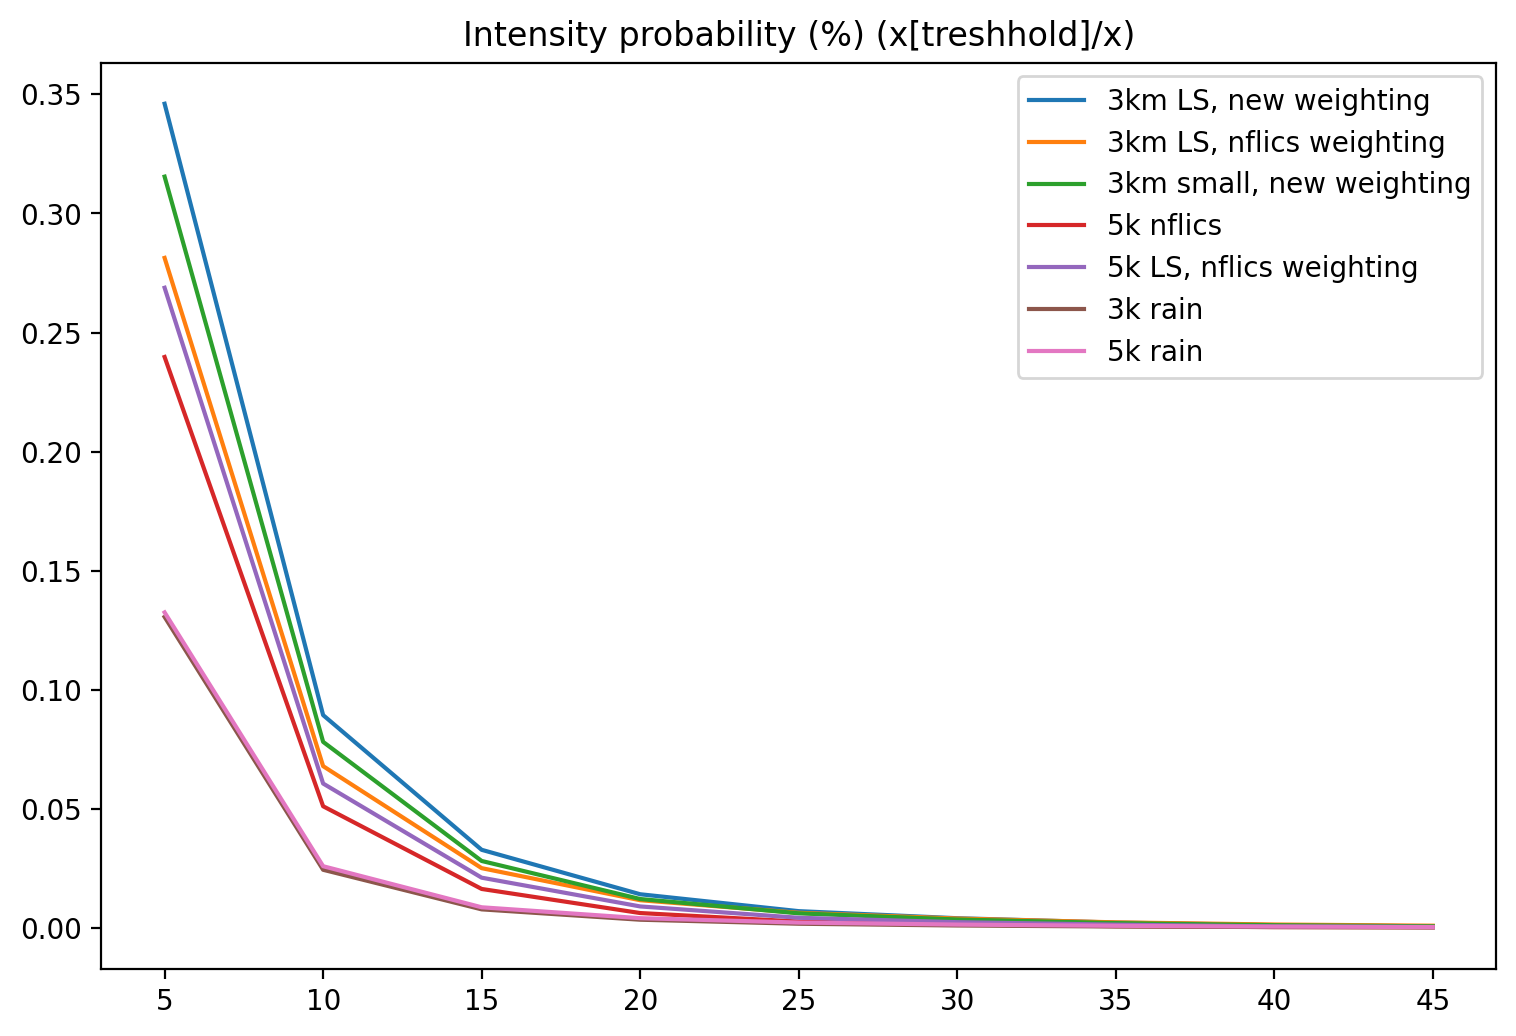

In [116]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS['rain'], '3km LS, new weighting'), (k3LS_grid['rain'], '3km LS, nflics weighting'),(k3['rain'], '3km small, new weighting'), (nflics['rain'], '5k nflics'), (nflicsLS['rain'], '5k LS, nflics weighting'), (alls3k, '3k rain'), (alls5k, '5k rain')]:
    treached = []
    for intens in range(5,50,5):
        cc = calc_treshReached(dat[0],intens)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability (%) (x[treshhold]/x)")
plt.legend()
 
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_95p_rainWav_southernAfricadomain.jpg')     

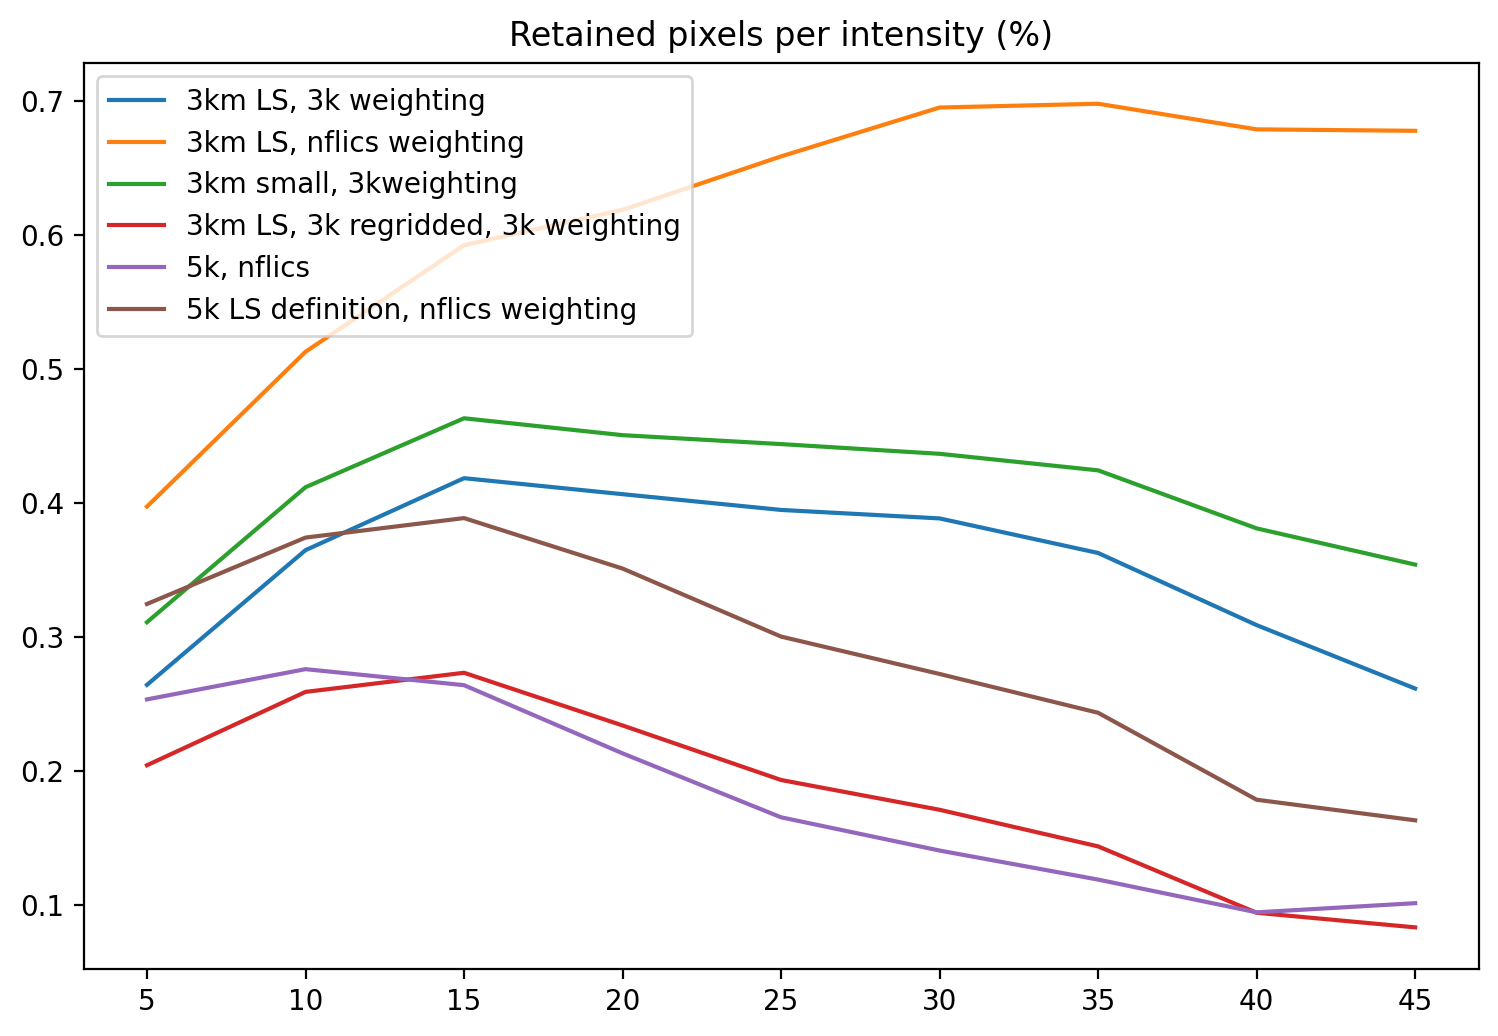

In [89]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting', alls3k), (k3LS_grid['rain'], '3km LS, nflics weighting', alls3k), (k3['rain'], '3km small, 3kweighting', alls3k), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting', alls3k_reg), (nflics['rain'], '5k, nflics', alls5k), (nflicsLS['rain'], '5k LS definition, nflics weighting', alls5k)]:
    treached = []
    for intens in range(5,50,5):
        cc = calc_treshMissed(dat[0],dat[2],intens)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Retained pixels per intensity (%)")
plt.legend()
 
f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'_missedCases_southernAfricaDomain.jpg')     

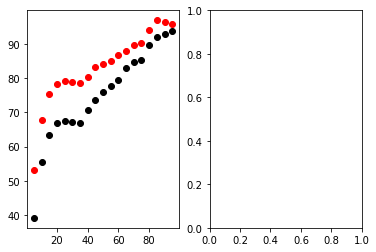

In [622]:
f = plt.figure()
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
for intens in np.arange(5,100,5):
    ax.scatter(intens, np.sum(np.array(k3LS['rain'])>intens)/np.sum(np.array(alls3k)>intens)*100, color='k')
    ax.scatter(intens, np.sum(np.array(k3LS_grid['rain'])>intens)/np.sum(np.array(alls3k)>intens)*100, color='r')

In [530]:
for i in range(0,24):
    print(str(i*60).zfill(4), i)

0000 0
0060 1
0120 2
0180 3
0240 4
0300 5
0360 6
0420 7
0480 8
0540 9
0600 10
0660 11
0720 12
0780 13
0840 14
0900 15
0960 16
1020 17
1080 18
1140 19
1200 20
1260 21
1320 22
1380 23
